# CART-POLE - REINFORCEMENT LEARNING
in this notebook i'll try to clean up this code by pytorch documentation. to hopefully make it more readable and easy to understand

## Imports

**general imports**

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from itertools import count

**torch imports**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

**initializing the env**

In [3]:
env = gym.make("CartPole-v1")

**set up matplotlib**

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()

if is_ipython:
    from IPython import display

plt.ion()

**set up gpu**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Build Memory

**making a deque memory space to remember the info from training**

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Build Agent

**build the model structure**

In [7]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_observations, 128), 
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
        )

    def forward(self, x):
        return self.layers(x)

## Train Model

**assigning some constants**

In [8]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# resetting the env so we can actually use it
state, info = env.reset()
n_actions = env.action_space.n
n_observations = len(state)

**network, optimizer, memory**

In [9]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

**function - select the next action (either random or by model prediction)**

In [10]:
steps_done = 0

def select_action(state):
    
    global steps_done
    sample = random.random()
    
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


**funtion - plot during training**

In [11]:
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

**function - optimize model (updates our model based on learnt data)**

In [12]:
def optimize_model():
    
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
   
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

**train model**

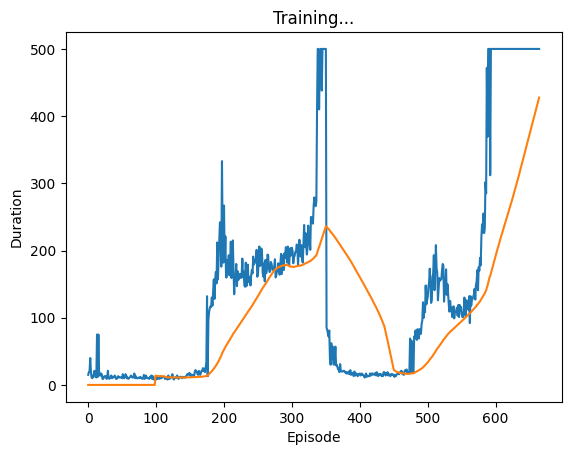

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available():
    num_episodes = 100
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

env.close()
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

**save model**

In [14]:
torch.save(target_net.state_dict(), "cartpole_model.pth")